In [228]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [196]:
wids = pd.read_csv("training_v2.csv")

In [197]:
cols = ['patient_id','hospital_id','hospital_death','age','bmi','elective_surgery','ethnicity','gender','height',
                   'hospital_admit_source','icu_admit_source','icu_id','icu_stay_type','icu_type',
                   'pre_icu_los_days','readmission_status','weight','h1_creatinine_max','h1_creatinine_min','h1_glucose_max','h1_glucose_min','h1_hco3_max','h1_hco3_min',
                   'h1_hemaglobin_max','h1_hemaglobin_min','h1_hematocrit_max','h1_hematocrit_min','h1_inr_max',
                  'h1_inr_min','h1_lactate_max','h1_lactate_min','h1_platelets_max','h1_platelets_min','h1_potassium_max',
                  'h1_potassium_min','h1_sodium_max','h1_sodium_min','h1_wbc_max','h1_wbc_min']
labs_subset = pd.DataFrame(wids, columns = cols)
labs_subset.head()

,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min
0,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,...,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7
2,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,...,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8
4,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
labs_subset.shape

(91713, 39)

In [199]:
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [200]:
null_values(labs_subset)

Dataframe has 39 columns.
There are 30 columns that have missing values.


,Missing Values,Percent of Total Values
h1_lactate_min,84369,92.0
h1_lactate_max,84369,92.0
h1_hco3_min,76094,83.0
h1_hco3_max,76094,83.0
h1_wbc_min,75953,82.8
h1_wbc_max,75953,82.8
h1_platelets_min,75673,82.5
h1_platelets_max,75673,82.5
h1_creatinine_max,74957,81.7
h1_creatinine_min,74957,81.7


#### Similar to other people - if you're missing one, you're missing the other. Also, the majority of people have the same min/max values. We need to decide if we want to keep all columns or if we want to make an assumption about keeping just max/min

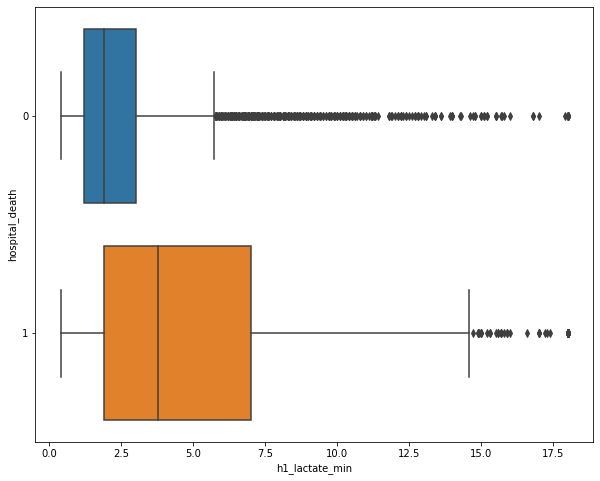

In [201]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x="h1_lactate_min", y="hospital_death", orient = "h", data=labs_subset)

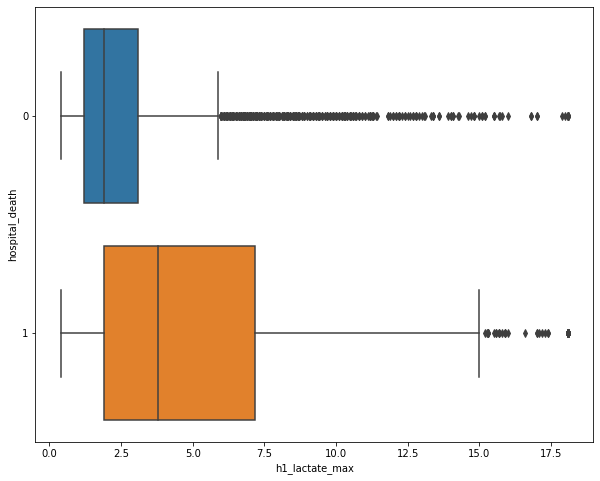

In [202]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x="h1_lactate_max", y="hospital_death", orient = "h", data=labs_subset)

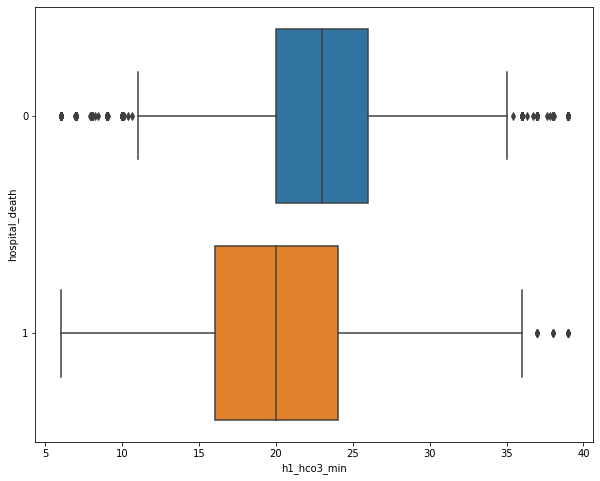

In [203]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x="h1_hco3_min", y="hospital_death", orient = "h", data=labs_subset)

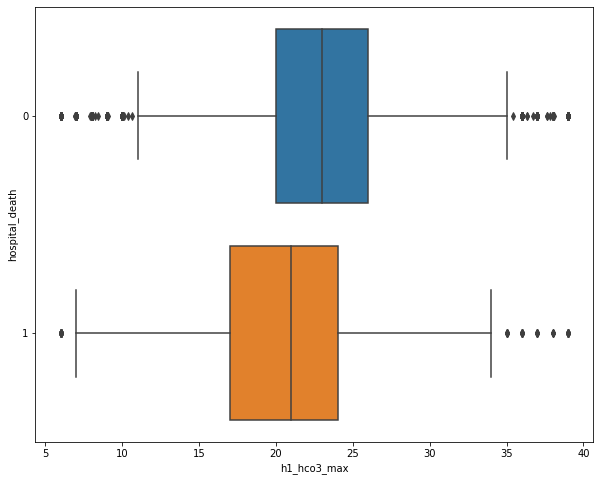

In [204]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x="h1_hco3_max", y="hospital_death", orient = "h", data=labs_subset)

In [205]:
labs_subset['h1_lactate'] = labs_subset[['h1_lactate_min', 'h1_lactate_max']].mean(axis=1)

In [206]:
labs_subset['h1_lactate'].head()

0    NaN
1    3.5
2    NaN
3    NaN
4    NaN
Name: h1_lactate, dtype: float64

In [207]:
new_subset = labs_subset.drop(columns=['h1_lactate_max','h1_lactate_min'])

In [208]:
new_subset.shape

(91713, 38)

In [209]:
new_subset['h1_creatinine'] = new_subset[['h1_creatinine_min', 'h1_creatinine_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_creatinine_min', 'h1_creatinine_max'])
new_subset.shape

(91713, 37)

In [210]:
new_subset['h1_glucose'] = new_subset[['h1_glucose_min', 'h1_glucose_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_glucose_min', 'h1_glucose_max'])
new_subset.shape

(91713, 36)

In [211]:
new_subset['h1_glucose'].describe()

count    39099.00000
mean       163.60393
std         91.10047
min         50.50000
25%        109.00000
50%        137.00000
75%        184.00000
max        682.52250
Name: h1_glucose, dtype: float64

In [212]:
labs_subset['h1_glucose_min'].describe()

count    39099.000000
mean       159.222742
std         89.157455
min         42.000000
25%        106.000000
50%        134.000000
75%        179.000000
max        670.000000
Name: h1_glucose_min, dtype: float64

In [213]:
labs_subset['h1_glucose_max'].describe()

count    39099.000000
mean       167.985117
std         94.721856
min         59.000000
25%        111.000000
50%        140.000000
75%        189.000000
max        695.045000
Name: h1_glucose_max, dtype: float64

In [214]:
new_subset['h1_hco3'] = new_subset[['h1_hco3_min', 'h1_hco3_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_hco3_min', 'h1_hco3_max'])
new_subset.shape

(91713, 35)

In [215]:
new_subset['h1_hemaglobin'] = new_subset[['h1_hemaglobin_min', 'h1_hemaglobin_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_hemaglobin_min', 'h1_hemaglobin_max'])
new_subset.shape

(91713, 34)

In [216]:
new_subset['h1_hematocrit'] = new_subset[['h1_hematocrit_min', 'h1_hematocrit_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_hematocrit_min', 'h1_hematocrit_max'])
new_subset.shape

(91713, 33)

In [217]:
new_subset['h1_inr'] = new_subset[['h1_inr_min', 'h1_inr_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_inr_min', 'h1_inr_max'])
new_subset.shape

(91713, 32)

In [218]:
new_subset['h1_platelets'] = new_subset[['h1_platelets_max', 'h1_platelets_min']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_platelets_max', 'h1_platelets_min'])
new_subset.shape

(91713, 31)

In [219]:
new_subset['h1_potassium'] = new_subset[['h1_potassium_min', 'h1_potassium_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_potassium_min', 'h1_potassium_max'])
new_subset.shape

(91713, 30)

In [220]:
new_subset['h1_sodium'] = new_subset[['h1_sodium_min', 'h1_sodium_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_sodium_min', 'h1_sodium_max'])
new_subset.shape

(91713, 29)

In [221]:
new_subset['h1_wbc'] = new_subset[['h1_wbc_min', 'h1_wbc_max']].mean(axis=1)
new_subset = new_subset.drop(columns = ['h1_wbc_min', 'h1_wbc_max'])
new_subset.shape

(91713, 28)

In [222]:
new_subset.columns.tolist()

['patient_id',
 'hospital_id',
 'hospital_death',
 'age',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 'weight',
 'h1_lactate',
 'h1_creatinine',
 'h1_glucose',
 'h1_hco3',
 'h1_hemaglobin',
 'h1_hematocrit',
 'h1_inr',
 'h1_platelets',
 'h1_potassium',
 'h1_sodium',
 'h1_wbc']

In [223]:
df1 = new_subset.drop('hospital_death', axis=1)
y = new_subset['hospital_death']
df1.shape

(91713, 27)

In [224]:
df1 = pd.get_dummies(df1)

In [225]:
df1 = df1.fillna(0)

In [226]:
# create training and testing vars
X_train, X_test, Y_train, Y_test = train_test_split(df1, y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(73370, 60) (73370,)
(18343, 60) (18343,)


In [229]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [230]:
acc_random_forest

100.0

In [231]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(1000)

,importance
feature,
pre_icu_los_days,0.088
patient_id,0.085
bmi,0.082
weight,0.078
age,0.075
height,0.066
h1_inr,0.066
icu_id,0.062
hospital_id,0.058


In [ ]:
# hd = wids[['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min',
# 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
# 'd1_diasbp_noninvasive_min', 'd1_heartrate_max',
# 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min',
# 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
# 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
# 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max',
# 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min',
# 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
# 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max',
# 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min',
# 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
# 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max',
# 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min',
# 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
# 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
# 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
# 'h1_sysbp_min', 'h1_sysbp_noninvasive_max',
# 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min',
# 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
# 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
# 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
# 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
# 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
# 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
# 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
# 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
# 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max',
# 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min',
# 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min',
# 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max',
# 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min',
# 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max',
# 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max',
# 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min',
# 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max',
# 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min',
# 'd1_arterial_pco2_max', 'd1_arterial_pco2_min',
# 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max',
# 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max',
# 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
# 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
# 'h1_arterial_po2_max', 'h1_arterial_po2_min',
# 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']]

# hd = hd[hd.columns.drop(hd.filter(regex = 'invasive'))]